If you haven't gone through [Carl's Tutorial](https://github.com/carlshan/intro_to_machine_learning/blob/master/lessons/Reinforcement_Learning/RL_Tutorial.md), you may want to go through that and implement the hill-climbing policy before attempting this tutorial. I would not recommend implementing the policy gradient strategy unless you're interested in learning more about lower-level tensorflow. This tutorial uses the keras, like the others this semester.

Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `pip3 install matplotlib --upgrade`

In [1]:
%matplotlib inline
import json
import numpy as np
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define the game environment and replay classes

In [2]:
class Throw(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.min_throw_center = 1
        self.max_throw_center = self.grid_size-2
        self.direction = 1
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        fruit_x, fruit_y, basket_center, throw_center, direction = self.state
        new_direction = direction
        throw = False
        if basket_center == self.grid_size-2:  # left
            new_direction = -1
        elif basket_center == 1: # right
            new_direction = 1
        movement = 0
        if action == 0:  # left
            movement = -1
        elif action == 1:  # right
            movement = 1
        elif action == 2: # throw
            throw = True
        else:
            raise Exception('Invalid action {}'.format(action))
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + new_direction), self.max_basket_center)
        new_throw_center = min(max(self.min_throw_center, throw_center + movement), self.max_throw_center)
        # move fruit down
        if throw == True or fruit_y>2:
            fruit_y += 1
        else:
            fruit_x = new_throw_center
        out = np.asarray([fruit_x, fruit_y, new_basket_center, new_throw_center, new_direction])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center, throw_center, direction = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        canvas[1, throw_center-1:throw_center + 2] = 1
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, basket_center, throw_center, direction = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) <= 1:
                return 1 # it caught the fruit
            else:
                return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        throw_center = random.randint(self.min_throw_center, self.max_throw_center)
        fruit_x = throw_center
        fruit_y = 2
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        direction = random.randint(0,1)*2-1
        self.state = np.asarray([fruit_x, fruit_y, basket_center, throw_center, direction])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i:i+1] = starting_observation
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




##  Functions for creating, training, and visualizing the model

In [3]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2), "mse")

    # Define environment/game
    env = Throw(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay


def train_model(model, env, exp_replay, num_episodes):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    catch_count = 0
    for episode in range(num_episodes):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()

        while not game_over:
            # get next action
            if np.random.rand() <= epsilon:
                # epsilon of the time, we just choose randomly
                action = np.random.randint(0, num_actions, size=1)
            else:
                # find which action the model currently thinks is best from this state
                q = model.predict(starting_observation)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            new_observation, reward, game_over = env.act(action)
            if reward == 1:
                catch_count += 1

            # store experience
            exp_replay.remember([starting_observation, action, reward, new_observation], game_over)

            # get data updated based on the stored experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            # train model on the updated data
            loss += model.train_on_batch(inputs, targets)

            starting_observation = new_observation # for next time through the loop

        # Print update from this episode
        print("Episode {:04d}/{:04d} | Loss {:.4f} | Catch count {}".format(episode, num_episodes-1, loss, catch_count))


def create_animation(model, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    observations = []
    for _ in range(num_games):
        env.reset()
        observation = env.observe()
        observations.append(observation)
        game_over = False
        while game_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, game_over = env.act(action)
            observations.append(observation)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [4]:
model, env, exp_replay = build_model()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


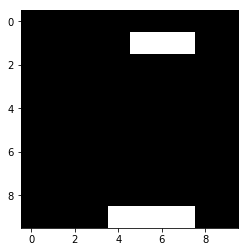

In [5]:
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

In [6]:
train_model(model, env, exp_replay, num_episodes=1000)
# animation = create_animation(model, env, num_games=10)
# IPython.display.HTML(animation.to_jshtml())

Episode 0000/0999 | Loss 0.2195 | Catch count 0
Episode 0001/0999 | Loss 0.1256 | Catch count 0
Episode 0002/0999 | Loss 0.1636 | Catch count 0
Episode 0003/0999 | Loss 0.0893 | Catch count 0
Episode 0004/0999 | Loss 0.0751 | Catch count 0
Episode 0005/0999 | Loss 0.0866 | Catch count 0
Episode 0006/0999 | Loss 0.0630 | Catch count 0
Episode 0007/0999 | Loss 0.1006 | Catch count 1
Episode 0008/0999 | Loss 0.0766 | Catch count 1
Episode 0009/0999 | Loss 0.1463 | Catch count 2
Episode 0010/0999 | Loss 0.1231 | Catch count 2
Episode 0011/0999 | Loss 0.3049 | Catch count 2
Episode 0012/0999 | Loss 0.2359 | Catch count 2
Episode 0013/0999 | Loss 0.1544 | Catch count 2
Episode 0014/0999 | Loss 0.1071 | Catch count 2
Episode 0015/0999 | Loss 0.0995 | Catch count 2
Episode 0016/0999 | Loss 0.0906 | Catch count 2
Episode 0017/0999 | Loss 0.1560 | Catch count 2
Episode 0018/0999 | Loss 0.0814 | Catch count 3
Episode 0019/0999 | Loss 0.2124 | Catch count 3
Episode 0020/0999 | Loss 0.1558 | Catch 

Episode 0169/0999 | Loss 0.0556 | Catch count 37
Episode 0170/0999 | Loss 0.1130 | Catch count 38
Episode 0171/0999 | Loss 0.5023 | Catch count 38
Episode 0172/0999 | Loss 0.0925 | Catch count 39
Episode 0173/0999 | Loss 0.1636 | Catch count 40
Episode 0174/0999 | Loss 0.0782 | Catch count 41
Episode 0175/0999 | Loss 0.0911 | Catch count 41
Episode 0176/0999 | Loss 0.0759 | Catch count 42
Episode 0177/0999 | Loss 0.0740 | Catch count 43
Episode 0178/0999 | Loss 0.1010 | Catch count 43
Episode 0179/0999 | Loss 0.0494 | Catch count 44
Episode 0180/0999 | Loss 0.0482 | Catch count 44
Episode 0181/0999 | Loss 0.0414 | Catch count 44
Episode 0182/0999 | Loss 0.0550 | Catch count 45
Episode 0183/0999 | Loss 0.1102 | Catch count 46
Episode 0184/0999 | Loss 0.0799 | Catch count 47
Episode 0185/0999 | Loss 0.2948 | Catch count 47
Episode 0186/0999 | Loss 0.0763 | Catch count 48
Episode 0187/0999 | Loss 0.0284 | Catch count 48
Episode 0188/0999 | Loss 0.1121 | Catch count 48
Episode 0189/0999 | 

Episode 0336/0999 | Loss 0.1745 | Catch count 111
Episode 0337/0999 | Loss 0.1478 | Catch count 112
Episode 0338/0999 | Loss 0.2002 | Catch count 112
Episode 0339/0999 | Loss 0.1706 | Catch count 112
Episode 0340/0999 | Loss 0.1682 | Catch count 112
Episode 0341/0999 | Loss 0.1743 | Catch count 112
Episode 0342/0999 | Loss 0.1159 | Catch count 113
Episode 0343/0999 | Loss 0.1268 | Catch count 114
Episode 0344/0999 | Loss 0.0894 | Catch count 114
Episode 0345/0999 | Loss 0.2013 | Catch count 115
Episode 0346/0999 | Loss 0.1269 | Catch count 115
Episode 0347/0999 | Loss 0.1419 | Catch count 116
Episode 0348/0999 | Loss 0.1293 | Catch count 117
Episode 0349/0999 | Loss 0.2038 | Catch count 117
Episode 0350/0999 | Loss 0.2323 | Catch count 117
Episode 0351/0999 | Loss 0.2154 | Catch count 117
Episode 0352/0999 | Loss 0.2037 | Catch count 118
Episode 0353/0999 | Loss 0.4126 | Catch count 119
Episode 0354/0999 | Loss 0.1755 | Catch count 120
Episode 0355/0999 | Loss 0.1677 | Catch count 121


Episode 0500/0999 | Loss 0.1379 | Catch count 206
Episode 0501/0999 | Loss 0.1423 | Catch count 206
Episode 0502/0999 | Loss 0.1458 | Catch count 207
Episode 0503/0999 | Loss 0.1356 | Catch count 207
Episode 0504/0999 | Loss 0.1050 | Catch count 207
Episode 0505/0999 | Loss 0.1333 | Catch count 207
Episode 0506/0999 | Loss 0.1278 | Catch count 207
Episode 0507/0999 | Loss 0.2267 | Catch count 208
Episode 0508/0999 | Loss 0.2591 | Catch count 208
Episode 0509/0999 | Loss 0.0997 | Catch count 209
Episode 0510/0999 | Loss 0.1742 | Catch count 209
Episode 0511/0999 | Loss 0.1945 | Catch count 210
Episode 0512/0999 | Loss 0.2103 | Catch count 210
Episode 0513/0999 | Loss 0.2210 | Catch count 211
Episode 0514/0999 | Loss 0.1464 | Catch count 212
Episode 0515/0999 | Loss 0.1653 | Catch count 213
Episode 0516/0999 | Loss 0.1137 | Catch count 214
Episode 0517/0999 | Loss 0.2734 | Catch count 214
Episode 0518/0999 | Loss 0.2404 | Catch count 214
Episode 0519/0999 | Loss 0.3042 | Catch count 215


Episode 0664/0999 | Loss 0.1007 | Catch count 264
Episode 0665/0999 | Loss 0.1914 | Catch count 265
Episode 0666/0999 | Loss 0.2097 | Catch count 265
Episode 0667/0999 | Loss 0.0747 | Catch count 265
Episode 0668/0999 | Loss 0.1449 | Catch count 266
Episode 0669/0999 | Loss 0.1475 | Catch count 266
Episode 0670/0999 | Loss 0.0778 | Catch count 266
Episode 0671/0999 | Loss 0.1843 | Catch count 267
Episode 0672/0999 | Loss 0.1807 | Catch count 267
Episode 0673/0999 | Loss 0.0870 | Catch count 267
Episode 0674/0999 | Loss 0.1902 | Catch count 268
Episode 0675/0999 | Loss 0.2215 | Catch count 269
Episode 0676/0999 | Loss 0.1224 | Catch count 270
Episode 0677/0999 | Loss 0.1345 | Catch count 270
Episode 0678/0999 | Loss 0.1440 | Catch count 270
Episode 0679/0999 | Loss 0.1720 | Catch count 270
Episode 0680/0999 | Loss 0.1839 | Catch count 270
Episode 0681/0999 | Loss 0.0786 | Catch count 271
Episode 0682/0999 | Loss 0.2331 | Catch count 271
Episode 0683/0999 | Loss 0.2074 | Catch count 271


Episode 0828/0999 | Loss 0.0782 | Catch count 332
Episode 0829/0999 | Loss 0.1935 | Catch count 332
Episode 0830/0999 | Loss 0.1906 | Catch count 332
Episode 0831/0999 | Loss 0.1227 | Catch count 333
Episode 0832/0999 | Loss 0.0996 | Catch count 334
Episode 0833/0999 | Loss 0.0663 | Catch count 334
Episode 0834/0999 | Loss 0.4346 | Catch count 334
Episode 0835/0999 | Loss 0.1676 | Catch count 334
Episode 0836/0999 | Loss 0.3349 | Catch count 334
Episode 0837/0999 | Loss 0.1221 | Catch count 334
Episode 0838/0999 | Loss 0.0928 | Catch count 334
Episode 0839/0999 | Loss 0.2300 | Catch count 334
Episode 0840/0999 | Loss 0.2155 | Catch count 334
Episode 0841/0999 | Loss 0.0505 | Catch count 335
Episode 0842/0999 | Loss 0.1424 | Catch count 335
Episode 0843/0999 | Loss 0.0459 | Catch count 336
Episode 0844/0999 | Loss 0.1014 | Catch count 336
Episode 0845/0999 | Loss 0.2549 | Catch count 336
Episode 0846/0999 | Loss 0.1161 | Catch count 337
Episode 0847/0999 | Loss 0.0887 | Catch count 337


Episode 0992/0999 | Loss 0.0673 | Catch count 414
Episode 0993/0999 | Loss 0.0837 | Catch count 415
Episode 0994/0999 | Loss 0.0795 | Catch count 416
Episode 0995/0999 | Loss 0.0805 | Catch count 417
Episode 0996/0999 | Loss 0.0735 | Catch count 417
Episode 0997/0999 | Loss 0.0735 | Catch count 418
Episode 0998/0999 | Loss 0.0634 | Catch count 418
Episode 0999/0999 | Loss 0.1401 | Catch count 418


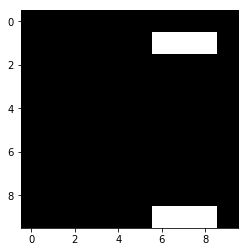

In [7]:
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises:
1. Add a validation function, to make it easier to assess models.
1. We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Change the code so that the basket is trying to avoid getting hit by the fruit.
1. Change the code so the game keeps going until the basket misses the fruit. (To test that this is working, you may want to change the number of games in the animation to 1.) How should this change the rewards that the model gets?
1. Change the game to something entirely different.
1. Try changing how the training works, using more of a policy gradient strategy.